In [56]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from classiq import *
from classiq.applications.iqae.iqae import IQAE

In [57]:
# How many qubits we want the quantum circuit to be
num_qubits = 7

# Mu (μ) represents the Average
mu = 0.7

# Sigma (σ) represents the Standard Deviation
sigma = 0.13

# The Alpha (α) parameter represents the probability in which P(X > v) = 1 - α
ALPHA = 0.07

# Find Alpha in a given precision
TOLERANCE = ALPHA / 10


def get_log_normal_probabilities(mu_normal, sigma_normal, num_points):
    log_normal_mean = np.exp(mu + sigma**2 / 2)
    log_normal_variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
    log_normal_stddev = np.sqrt(log_normal_variance)

    # cutting the distribution 3 sigmas from the mean
    low = np.maximum(0, log_normal_mean - 3 * log_normal_stddev)
    high = log_normal_mean + 3 * log_normal_stddev
    print(log_normal_mean, log_normal_variance, log_normal_stddev, low, high)
    x = np.linspace(low, high, num_points)
    return x, scipy.stats.lognorm.pdf(x, s=sigma_normal, scale=np.exp(mu_normal))


# %%
grid_points, probs = get_log_normal_probabilities(mu, sigma, 2**num_qubits)

2.030841014265948 0.07029323208790372 0.26512870853210846 1.2354548886696226 2.8262271398622736


Value at risk at 7%: 1.6613309244219858


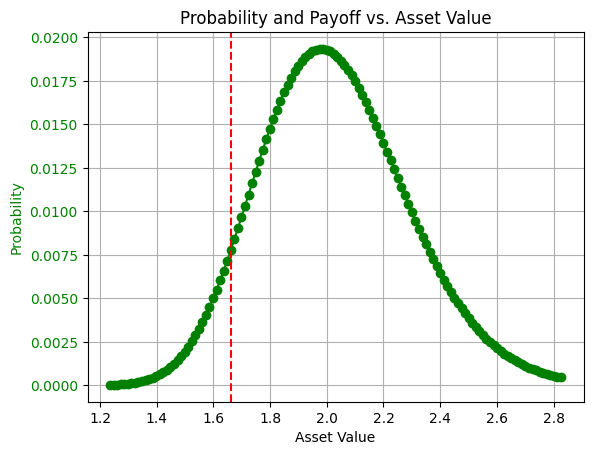

In [58]:
probs = (probs / np.sum(probs)).tolist()

fig, ax1 = plt.subplots()

# Plotting the log-normal probability function
ax1.plot(grid_points, probs, "go-", label="Probability")  # Green line with circles
ax1.tick_params(axis="y", labelcolor="g")
ax1.set_xlabel("Asset Value")
ax1.set_ylabel("Probability", color="g")

# Adding grid and title
ax1.grid(True)
plt.title("Probability and Payoff vs. Asset Value")

VAR = 0
# Find the value at risk ALPHA of grid_points
accumulated_value = 0

for index in range(len(probs)):
    accumulated_value += probs[index]
    if accumulated_value > ALPHA:
        VAR = grid_points[index]
        break

print(f"Value at risk at {int(ALPHA*100)}%: {VAR}")

# Plot the vertical line of VaR at 5%
ax1.axvline(x=VAR, color="r", linestyle="--", label="VaR at 5%")

In [59]:
def get_initial_index():
    return int(2**num_qubits) // 4

In [60]:
def update_index(index: int, required_alpha: float, alpha_v: float, search_size: int):
    if alpha_v < required_alpha:
        return index + search_size
    return index - search_size

In [61]:
# This function calculates the alpha classically given the index and the list of probabilities


def calc_alpha(index: int, probs: list[float]):
    sum_probs = sum([probs[i] for i in range(index)])
    return sum_probs

In [62]:
import numpy as np

def rbf_kernel(x1, x2, length_scale=5.0, sigma_f=1.0):
    """
    Radial Basis Function kernel for 1D inputs
    """
    x1 = np.array(x1).reshape(-1,1)
    x2 = np.array(x2).reshape(-1,1)
    sqdist = (x1 - x2.T)**2
    return sigma_f**2 * np.exp(-0.5 * sqdist / length_scale**2)

def value_at_risk_bayesian_noskl(required_alpha, num_shots, calc_alpha_func, grid_points, max_iter=20, tolerance=0.005):
    """
    Bayesian search for VaR without sklearn.
    grid_points: list of thresholds
    calc_alpha_func: returns (F_L(x), confidence_interval)
    """
    X_obs = []
    Y_obs = []

    # 1) Initial random points
    initial_indices = np.random.choice(len(grid_points), size=3, replace=False)
    for idx in initial_indices:
        idx = int(idx)
        F_x, ci = calc_alpha_func(idx, grid_points, num_shots)
        X_obs.append([idx])
        Y_obs.append(F_x)
        print(f"Initial idx={idx}, F_L={F_x:.4f}, CI={ci}")

    X_obs = np.array(X_obs)
    Y_obs = np.array(Y_obs)

    for iteration in range(max_iter):
        # Compute kernel matrices
        K = rbf_kernel(X_obs, X_obs) + 1e-6 * np.eye(len(X_obs))
        K_inv = np.linalg.inv(K)

        # Predict mean and std for all candidates
        X_candidates = np.arange(len(grid_points)).reshape(-1,1)
        K_s = rbf_kernel(X_candidates, X_obs)
        K_ss = rbf_kernel(X_candidates, X_candidates) + 1e-6 * np.eye(len(X_candidates))

        mu = K_s @ K_inv @ Y_obs
        cov = K_ss - K_s @ K_inv @ K_s.T
        sigma = np.sqrt(np.maximum(np.diag(cov), 1e-10))

        # Expected Improvement acquisition
        ei = (required_alpha - mu) * sigma
        ei[ei < 0] = 0
        next_idx = int(np.argmax(ei))

        # Evaluate next point
        F_next, ci = calc_alpha_func(next_idx, grid_points, num_shots)
        print(f"Iteration {iteration}: idx={next_idx}, F_L={F_next:.4f}, CI={ci}")

        # Update observations
        X_obs = np.vstack([X_obs, [next_idx]])
        Y_obs = np.append(Y_obs, F_next)

        # Stop if close enough
        if abs(F_next - required_alpha) < tolerance:
            print(f"Found VaR threshold: index={next_idx}, F_L={F_next:.4f}")
            return grid_points[next_idx]

    # Return closest after max_iter
    best_idx = np.argmin(np.abs(Y_obs - required_alpha))
    print(f"Max iterations reached. Best index={best_idx}, F_L={Y_obs[best_idx]:.4f}")
    return grid_points[best_idx]


In [63]:
@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)


@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)


@qperm
def payoff(asset: Const[QNum], ind: QBit):
    ind ^= asset < GLOBAL_INDEX

In [64]:
written_qmod = False


def calc_alpha_quantum(index: int, probs: list[float], num_shots: int):

    # Global variable
    global GLOBAL_INDEX
    GLOBAL_INDEX = index

    # Creation of the model, given the constratins and the circuit preferences
    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=num_qubits,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=num_qubits)
    )

    qprog = iqae.get_qprog()

    global written_qmod
    qmod = iqae.get_model()
    if not written_qmod:
        written_qmod = True
        show(qprog)

    iqae_res = iqae.run(epsilon=0.05, alpha=0.01)

    # Result of the iterative QAE
    # iqae_res = res[0].value
    measured_payoff = iqae_res.estimation
    confidence_interval = np.array(
        [interval for interval in iqae_res.confidence_interval]
    )
    print("Measured Payoff:", measured_payoff)
    print("Confidence Interval:", confidence_interval)
    return measured_payoff, confidence_interval

In [65]:
index = get_initial_index()

In [ ]:
shot_sizes = [200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]
rmse_history = []

for num_shots in shot_sizes:
    print(f"======= Running {num_shots} shots =======\n")
    var = value_at_risk_bayesian_noskl(
        required_alpha=ALPHA,
        num_shots=num_shots,
        calc_alpha_func=calc_alpha_quantum,
        grid_points=probs
    )
    rmse_history.append((VAR - var)**2.)

======= Running 200 shots =======

Quantum program link: https://platform.classiq.io/circuit/3937ZK5gpbJKH88nSkfeQ7kTKY3


https://platform.classiq.io/circuit/3937ZK5gpbJKH88nSkfeQ7kTKY3?login=True&version=16

Measured Payoff: 0.2060546875
Confidence Interval: [0.1665357  0.24557368]
Initial idx=47, F_L=0.2061, CI=[0.1665357  0.24557368]
Measured Payoff: 0.002795458727140358
Confidence Interval: [0.00191195 0.00367897]
Initial idx=14, F_L=0.0028, CI=[0.00191195 0.00367897]
Measured Payoff: 0.7578125
Confidence Interval: [0.71829351 0.79733149]
Initial idx=78, F_L=0.7578, CI=[0.71829351 0.79733149]
Measured Payoff: 0.9973353442901002
Confidence Interval: [0.99645567 0.99821502]
Iteration 0: idx=123, F_L=0.9973, CI=[0.99645567 0.99821502]
Measured Payoff: 0.00040857060788183317
Confidence Interval: [0.         0.00081714]
Iteration 1: idx=0, F_L=0.0004, CI=[0.         0.00081714]
Measured Payoff: 0.9489412673085429
Confidence Interval: [0.94436378 0.95351876]
Iteration 2: idx=100, F_L=0.9489, CI=[0.94436378 0.95351876]
Measured Payoff: 0.027946223726213186
Confidence Interval: [0.02532592 0.03056652]
Iteration 3: idx=27, F_L=0.0279, CI=[0.02532592 0.03056652]
Measured Payoff: 0.486328125
Confi

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --------------------------
# 1) Define data
# --------------------------

# Indices for the second output (example: idx values)
indices_2 = [
    [47, 14, 78, 123, 0, 100, 27, 61, 7, 35],          # 200 shots
    [92, 4, 1, 44, 127, 21, 67, 109, 30, 13],         # 500 shots
    [23, 6, 50, 94, 127, 71, 34],                     # 1000 shots
    [54, 27, 44, 98, 0, 127, 75, 12, 19, 6, 112, 33, 23, 30, 9, 1, 21, 32, 17, 25, 4],  # 2000 shots
    [17, 31, 6, 74, 119, 51]                          # 5000 shots
]

# Measured payoffs for each shot size
payoffs_2 = [
    [0.2060546875, 0.002795458727140358, 0.7578125, 0.9973353442901002, 0.00040857060788183317, 0.9489412673085429, 0.027946223726213186, 0.486328125, 0.000697720991496474, 0.07415970045608669],
    [0.9052451031999573, 0.0004957755556047786, 0.000413686692125359, 0.1715122955393033, 0.9993335209667367, 0.010764008432665083, 0.5849609375, 0.9785223066755564, 0.0411051109252704, 0.0024479090223187318],
    [0.015656294960135497, 0.0006197351239753149, 0.251953125, 0.9167016755244348, 0.9993231140556227, 0.65478515625, 0.06527197481113628],
    [0.31982421875, 0.0275261336855879, 0.17300049620432575, 0.9387345582611599, 0.00040857060788183317, 0.9993387217743144, 0.7060546874999999, 0.0015751566777913997, 0.007310458389191156, 0.0006249218653668771,
     0.9845476361943313, 0.058196869256421396, 0.014568974987980477, 0.00047007581982923957, 0.0037162297318035125, 0.0008493973407432099, 0.00042904512291576006, 0.01063370455449524, 0.050096468332356314, 0.0044578901591612805, 0.02051767440444722, 0.0005369845212108553],
    [0.005017920822774651, 0.04589516661277024, 0.000604185404489449, 0.71142578125, 0.9943267528273739, 0.27392578124999994]
]

# Confidence intervals (just lower and upper bounds)
ci_2 = [
    [(0.1665357, 0.24557368), (0.00191195, 0.00367897), (0.71829351, 0.79733149), (0.99645567, 0.99821502), (0., 0.00081714), (0.94436378, 0.95351876), (0.02532592, 0.03056652), (0.44680914, 0.52584711), (0., 0.00139544), (0.07178144, 0.07653796)],
    [(0.90174314, 0.90874706), (0., 0.00099155), (0., 0.00082737), (0.16815095, 0.17487364), (0.99866704, 1.), (0.00959124, 0.01193678), (0.54544195, 0.62447993), (0.97621953, 0.98082508), (0.03758545, 0.04462477), (0.00157454, 0.00332128)],
    [(0.01359175, 0.01772084), (0., 0.00123947), (0.21243414, 0.29147211), (0.90929503, 0.92410832), (0.99864623, 1.), (0.61526617, 0.69430414), (0.06309651, 0.06744744)],
    [(0.28030523, 0.35934321), (0.02492844, 0.03012382), (0.17066958, 0.17533141), (0.93240696, 0.94506216), (0., 0.00081714), (0.99867744, 1.), (0.6665357, 0.74557368), (0.00072653, 0.00242378), (0.00627796, 0.00834295), (0., 0.00124984),
     (0.98249075, 0.98660452), (0.05199269, 0.06440105), (0.01254478, 0.01659317), (0., 0.00094015), (0.002805, 0.00462746), (2.05854703e-05, 1.67820921e-03), (0., 0.00085809), (0.00946673, 0.01180068), (0.04564239, 0.05455055), (0.00352341, 0.00539237), (0.01825698, 0.02277837), (0., 0.00107397)],
    [(0.0040653, 0.00597054), (0.04192177, 0.04986856), (0., 0.00120837), (0.67190679, 0.75094477), (0.99335225, 0.99530125), (0.23440679, 0.31344477)]
]

# Shot sizes
shot_sizes_2 = [200, 500, 1000, 2000, 5000]

# --------------------------
# 2) Plot measured payoffs with confidence intervals
# --------------------------
plt.figure(figsize=(14, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(shot_sizes_2)))

for i, shots in enumerate(shot_sizes_2):
    payoffs = payoffs_2[i]
    ci = ci_2[i]
    lower = [c[0] for c in ci]
    upper = [c[1] for c in ci]
    inds = indices_2[i]
    
    plt.plot(inds, payoffs, marker='o', label=f'{shots} shots', color=colors[i])
    plt.fill_between(inds, lower, upper, color=colors[i], alpha=0.2)

plt.xlabel("Index / Threshold")
plt.ylabel("Measured Payoff / Probability")
plt.title("Comparison of Measured Payoffs (Second Output)")
plt.legend()
plt.grid(True)
plt.show()
